# Zadatak 2 - genetski algoritam

**NAPOMENA**: Nemojte koristiti ruletsku selekciju vec turnirsku.

In [66]:
# NOTE: sa IDENTICNIM parametrima(u svim funkcijama) kao u resenju, 
# moj kod daje mnogo losije resenje, nisam nasao zasto

import random
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

Učitava se ciljna slika.

In [67]:
target_image = Image.open('genetic_target2.jpg').convert('L')
image_size = (30, 30)
show_size = (300, 300)
target_image = target_image.resize(image_size, Image.ANTIALIAS)
print('shape', target_image.size)

shape (30, 30)


Prebacuje se slika u `numpy` vektor.

In [68]:
# Prebacujemo sliku u numpy vector
target = np.array(target_image).ravel()
print(target.shape)

(900,)


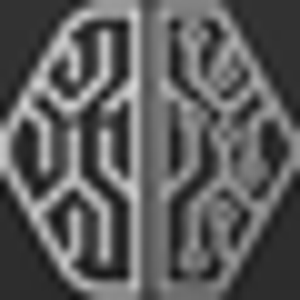

In [69]:
target_image.resize(show_size)

In [70]:
class Chromosome:
    '''
    Predstavlja jedan hromozom, odnosno jednu sliku.
    Slika je data genetskim kodom i ocenom prilagodjenosti 
    '''
    def __init__(self, genetic_code, fitness):
        self.genetic_code = genetic_code
        self.fitness = fitness
    
    def __str__(self):
        return "image of shape {} = {}".format(self.genetic_code.shape, self.fitness)

**NAPOMENA**: Nemojte koristiti ruletsku selekciju vec turnirsku.

In [71]:
class GeneticAlgorithm:
    '''
    Klasa predstavlja implementaciju genetskog algoritma za resavanje problema pogadjanja niske.
    Koristi se:
    - Jednopoziciono ukrstanje sa nasumicnom tackom ukrstanja
    - Mutacija sa verovatnocom '_mutation_rate'
    - Ruletska selekcija ili turnirska selekcija u zavisnosti od parametra self.selection_type
    - Zamena generacije se vrsi tako sto se od jedinki izabranih pri selekciji ukrstanjem
        pravi celokupna nova generacija (pogledati u knjizi alternativne zamene generacija)
    '''
    def __init__(self, possible_gene_values, target):
        self.target = target                                     # Slika koja se pogadja
        self.gene_length = target.shape                          # Ukupan broj piksela u slici koja se pogadja
        self.possible_gene_values = possible_gene_values         # Dozvoljene vrednosti koje mogu biti u genu
        self.num_gene_values = possible_gene_values.shape[0]     # Duzina dozvoljenih vrednosti
        
        '''Parametri genetskog algoritma, eksperimentalno izabrani.'''
        self.generation_size = 2000                              # Broj jedinki u jednoj generaciji
        self.chromosome_size = len(target)                       # Duzina hromozoma
        self.reproduction_size = 500                             # Broj jedinki koji ucestvuje u reprodukciji    
        self.max_iterations = 400                                # Maksimalni dozvoljeni broj iteracija
        self.mutation_rate = 0.1                                 # Verovatnoca da se desi mutacija
        self.tournament_size = 10                                # Velicina turnira
        
        # Vrsta selekcije, moze biti turnirska (tournament) ili ruletska (roulette)
        self.selection_type = 'tournament'      

   
    def calculate_fitness(self, genetic_code):
        '''Vraca broj karaktera koji se u genu poklapaju sa pravom vrednoscu.'''
        fitness = np.sum((genetic_code - self.target) ** 2)
        return fitness
        
    def initial_population(self):
        '''Generise se _generation_size nasumicnih jedinki.'''
        init_population = []
        
        for i in range(self.generation_size):
            # generise se i-ti nasumicni genetski kod
            genetic_code = np.random.randint(0, 256, size=self.gene_length)
            
            # ----------------------------------------------------------------
            # STUDENTSKI KOD
            # ----------------------------------------------------------------
            init_population.append( Chromosome(genetic_code, self.calculate_fitness(genetic_code)) )
            # ----------------------------------------------------------------
            
        return init_population
    
    def selection(self, chromosomes):
        '''Funkcija za izbor hromozoma za reporodukciju'''
        selected = []
        
        # Bira se self.reproduction_size hromozoma za reprodukciju
        # Selekcija moze biti ruletska ili turnirska
        for i in range(self.reproduction_size):
            if self.selection_type == 'roulette':
                selected.append(self.roulette_selection(chromosomes))
            elif self.selection_type == 'tournament':
                selected.append(self.tournament_selection(chromosomes))
          
        # Vracaju se izabrani hromozomi za repodukciju
        return selected
    
    def roulette_selection(self, chromosomes):
        '''
        Bira jednu jedinku koristeci ruletsku selekciju. Ne vrsi normalizaciju
        i sortiranje po funkciji prilagodjenosti usled performansi.
        '''
        # suma svih prilagodjenosti
        total_fitness = sum([chromosome.fitness for chromosome in chromosomes])
        
        # bira se neka random vrednost, sluzi za 'imitiranje' slucajnosti 
        selected_value = random.randrange(0, -total_fitness)
        
        current_sum = 0
        for i in range(self.generation_size):
            current_sum += chromosomes[i].fitness

            # vraca se prva jedinka koja ispuni uslov
            if current_sum > selected_value:
                return chromosomes[i]
    
    def tournament_selection(self, chromosomes):
        '''Bira jednu jedinku koristeci turnirsku selekciju. '''
        # Bira se self.tournament_size jediniki za turnir
        selected = random.sample(chromosomes, self.tournament_size)
        
        # Pobednik je onaj sa minimalnom ocenom prilagođenosti
        # jer želimo da minimiziramo grešku.
        winner = min(selected, key = lambda x: x.fitness)
        
        return winner
        
    
    def mutate(self, genetic_code):
        '''
        Vrsi mutaciju nad hromozomom sa verovatnocom self._mutation_rate.
        Mutacija se vrsi nad jednim genom (karakterom) sa proizvoljnim indeksom.
        '''
        random_value = random.random()
        
        # ukoliko je ispunjen uslov, izvrsi mutaciju
        if random_value < self.mutation_rate:
            
            # izabrati proizvoljan indeks
            random_index = random.randrange(self.chromosome_size)
            
            while True:
                # izabrati novu proizvoljnu vrednost za karakter
                new_value = random.choice(self.possible_gene_values)
                
                # ukoliko su vrednosti razlicite, izmeni karakter
                if genetic_code[random_index] != new_value:
                    break
                    
            genetic_code[random_index] = new_value
            
        return genetic_code
        
    
    def create_generation(self, chromosomes):
        '''
        Od jedinki generise novu generaciju primenjujuci genetske operatore 
        ukrstanje (crossover) i mutaciju (mutation). 
        '''
        generation = []
        generation_size = 0
        
        while generation_size < self.generation_size:
            # Proizvoljno se biraju 2 roditelja za ukrstanje
            [parent1, parent2] = random.sample(chromosomes, 2)
            
            # Dobijaju se 2 detata ukrstanjem
            # ----------------------------------------------------------------
            # STUDENTSKI KOD
            # ----------------------------------------------------------------
            child1_code, child2_code = self.crossover(parent1, parent2) 
            # ----------------------------------------------------------------
            
            # Vrsi se mutacija nad decom
            # ----------------------------------------------------------------
            # STUDENTSKI KOD
            # ----------------------------------------------------------------
            child1_code = self.mutate(child1_code)
            child2_code = self.mutate(child2_code)
            # ----------------------------------------------------------------
            
            # Prave se novi hromozomi
            child1 = Chromosome(child1_code, self.calculate_fitness(child1_code))
            child2 = Chromosome(child2_code, self.calculate_fitness(child2_code))
            
            # Dodaju se u generaciju
            generation.append(child1)
            generation.append(child2)
            
            generation_size += 2
            
        return generation
            
    '''Jednopoziciono ukrstanje sa nasumicnom tackom ukrstanja'''
    def crossover(self, parent1, parent2):
        # bira se proizvoljna tacka ukrstanja
        break_point = random.randrange(1, self.chromosome_size)
        
        child1 = np.concatenate((parent1.genetic_code[:break_point], parent2.genetic_code[break_point:]))
        child2 = np.concatenate((parent2.genetic_code[:break_point], parent1.genetic_code[break_point:]))
        
        return (child1, child2)
        
    '''Izvrsavanje genetskog algoritma'''
    def optimize(self):
        # Generisi pocetnu populaciju jedinki i izracunaj
        # prilagodjenost svake jedinke u populaciji
        population = self.initial_population()
        global_best_chromosome = population[0]
        
        # Korak za prikaz optimizacije (kako se ne bi prepunila konzola)
        log_step = int(0.1 * self.max_iterations)
        for i in range(1, self.max_iterations+1):
            # Prikazujemo korisniku dokle se stiglo sa optimizacijom
            if i % log_step == 0 or i == self.max_iterations:
                print(f'Progress: {i / self.max_iterations * 100}% iterations: {i}/{self.max_iterations} done')
                
            # ----------------------------------------------------------------
            # STUDENTSKI KOD
            # ----------------------------------------------------------------
            selection = self.selection(population)
            population = self.create_generation(selection)
            for chromosome in population:
                fitness = chromosome.fitness
                if global_best_chromosome.fitness < chromosome.fitness:
                    global_best_chromosome = chromosome
            # ----------------------------------------------------------------
            
            if global_best_chromosome.fitness == self.chromosome_size:
                break
            
        return global_best_chromosome
 

Generišemo vektor brojeva koji predstavlja skup dozvoljenih vrednosti za gen.

In [72]:
allowed_gene_values = np.arange(0, 256)

In [73]:
genetic_algorithm = GeneticAlgorithm(allowed_gene_values, target)

Savet: Tokom rada moze vam biti korisno da smanjite parametre genetskog algoritma kako bi se brze izracunavao. Kada budete sigurni
da ste pri kraju onda ih mozete povecati i pokusati da dobijete aproksimaciju resenja.

In [74]:
result = genetic_algorithm.optimize()

Progress: 10.0% iterations: 50/500 done
Progress: 20.0% iterations: 100/500 done
Progress: 30.0% iterations: 150/500 done
Progress: 40.0% iterations: 200/500 done
Progress: 50.0% iterations: 250/500 done
Progress: 60.0% iterations: 300/500 done
Progress: 70.0% iterations: 350/500 done
Progress: 80.0% iterations: 400/500 done
Progress: 90.0% iterations: 450/500 done
Progress: 100.0% iterations: 500/500 done


In [75]:
print('Result: {}'.format(result))

Result: image of shape (900,) = 8845700


Poredimo generisanu sliku naspram ciljane slike

In [76]:
np_result = result.genetic_code.reshape(image_size)

In [77]:
tmp = np.uint8(np_result)
tmp.shape

(30, 30)

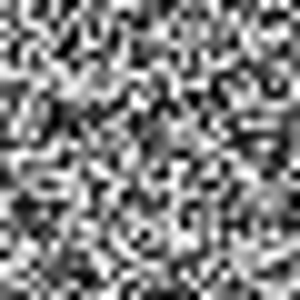

In [78]:
pil_img = Image.fromarray(tmp)
pil_img.resize(show_size)

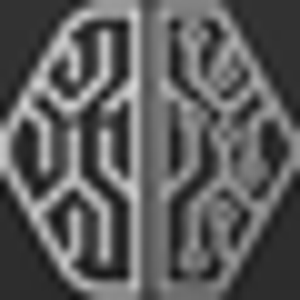

In [79]:
target_image.resize((300, 300))

Važan komentar. Dozvoljeno je da modifikujete parametre genetskog algoritma. Zadatak neće biti maksimalno bodova
ukoliko ne uspete da dobijete sliku koja iole podseća na ciljnu sliku. Velika količina šuma je dozvoljena, ali
je važno da se dobije donekle neka aproksimacija ciljne slike.

Na primer, slika u nastavku je jedno moguće dobijeno rešenje. Vaša može biti i bolja, ali i naravno lošija, samo
je važno da se uoči da neka sličnost sa ciljnom slikom.

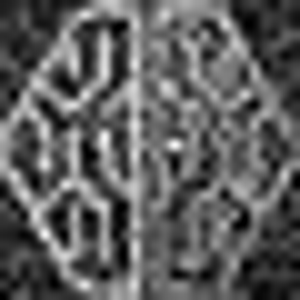

In [80]:
Image.open('genetic_solution.png').convert('L').resize(show_size)